In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV,  cross_val_score, KFold

def get_train_data():
    from pymongo import MongoClient
    import pandas as pd

    connection = MongoClient('ds149279.mlab.com', 49279)
    db = connection['data602final']
    db.authenticate('me', 'mypass')
    
    df = pd.DataFrame([item for item in db.btc_options.find({})])
    sds = pd.DataFrame([item for item in db.sds.find({})])
    return df, sds
df, sds = get_train_data()

ModuleNotFoundError: No module named 'trade_analysis'

# Data Munging

In [5]:
def strike_dist(df):
    if df.option_type == 'C':
        return (df.indexPrice - df.strike)/df.strike
    else:
        return (df.strike - df.indexPrice)/df.strike
    
def black_scholes(df, option_type):
    from scipy.stats import norm
    import numpy as np
    
    current = df.indexPrice.values
    rf = df['rf'].values
    t = (df.expiration_date.values - df.timeStamp.values).astype('timedelta64[s]').astype(float)/(365*86400)
    top_d1 = np.log(current/df.strike.values) + (rf + ((df.sd.values)**2)/2)*t
    bottom_d1 = df.sd.values*np.sqrt(t)
    d1 = top_d1/bottom_d1

    d2 = d1 - df.sd.values*np.sqrt(t)
    if option_type == 'C':
        return current*norm.cdf(d1) - df.strike.values*np.exp(-rf*t)*norm.cdf(d2)
    else:
        return df.strike.values*np.exp(-rf*t)*norm.cdf(-d2) - current*norm.cdf(-d1)

In [6]:
def prep_data(sds, df):
    import pandas as pd
    from datetime import datetime, timedelta
    from quandl import get

    
    
    get_date = lambda x: datetime.strptime(x, '%d%b%y')
    
    get_cols = lambda x: pd.Series([item for item in x.split('-')])
    cols = df['instrument'].apply(get_cols)
    cols.columns = ['uderlying', 'expiration_date', 'strike', 'option_type']
    df = pd.concat([df, cols], axis = 1)
    df.loc[:, 'expiration_date'] = df['expiration_date'].map(get_date)
    add_time = lambda x: timedelta(days = 1) - timedelta(seconds = 1) + x #make exp date end of day
    df['expiration_date'] = df['expiration_date'].map(add_time)
    
    df = df.dropna()
    df['strike'] = df['strike'].map(int)
    df['timeStamp'] = df['timeStamp'].map(lambda x: datetime.fromtimestamp(x/1000))
    df['time_left'] = (df['expiration_date'] - 
      df['timeStamp']).values.astype('timedelta64[s]').astype(float)/(365*86400)
    df['date'] = df['timeStamp'].map(lambda x: x.date())
    sds['date'] = sds['date'].map(lambda x: x.date())
    rf = get('FRED/DTB6', start_date = '2016-01-01')/100
    rf.loc[:, 'date'] = rf.index.values
    rf['date'] = rf['date'].map(lambda x: x.date())
    rf.rename(columns = {'Value': 'rf'}, inplace = True)
    
    
    df = pd.merge(df, sds, on = ['date'])
    df = pd.merge(df, rf, on = ['date'])
    
    
    calls = df.loc[df.option_type == 'C']
    puts = df.loc[df.option_type == 'P']
    
        
    call_prices = black_scholes(calls, 'C')
    put_prices = black_scholes(puts, 'P')
    calls.loc[:, 'bs_price'] = call_prices
    puts.loc[:, 'bs_price'] = put_prices
    
    df2 = pd.concat([calls, puts], axis = 0)
    
    
        
    df2['strike_dist'] = df2.apply(strike_dist, axis = 1)
    
    df2['price'] = df2.apply(lambda x: x.price * x.indexPrice, axis = 1)#option price converted to USD
    df2['price_delta'] = df2.apply(lambda x: 
        min(max((x.bs_price - x.price)/x.price, -2), 2), axis = 1)#difference between option price and
    #price predicted by BS formula
    
    df2.sort_values(['instrument', 'tradeSeq'], inplace = True)
    grouped = df2.groupby(['instrument'])['quantity'].cumsum()
    df2.loc[:, 'cum_volume'] = grouped
    df2.sort_values(['instrument', 'tradeSeq'], ascending  = False, inplace = True)
    
    #this operation should be a function for style
    #get the price 2 trades in the future.  We can play around with this number
    df2.loc[:,'fut_option_price'] = df2.groupby(['instrument']).price.shift(2)
    df2.loc[:,'fut_und_price'] = df2.groupby(['instrument']).indexPrice.shift(2)
    df2.loc[:,'fut_bs_price'] = df2.groupby(['instrument']).bs_price.shift(2)
    df2['price_change'] = (df2.fut_option_price - df2.price)/df2.price
    df2['index_change'] = df2.fut_und_price - df2.indexPrice
    df2['net_change'] = df2.apply(
            lambda x: min(max(x.price_change - (x.fut_bs_price - x.bs_price)/x.bs_price, -2), 2), axis = 1)
    
    #I'm still not 100% sure net_change is the value we want to predict.  Here's my thinking:
    #The idea is that we want measure of price change
    #that is independent of price changes in the underlying.  With net change, if the underlying didn't change,
    #future_bs_price - bs_price should be zero, so we're left with the price change.  For a call, if the underlying
    #goes up, the fut_bs_price - bs_price will be positive, and should offset the part of the price change due to
    #a change in price in the underlying.  What you're left with is any change in price due to the option valuation
    #getting closer to a fair value
    
    opt_map = {'C': 1, 'P': 2}
    
    
    df2['option_type'] = df2['option_type'].map(lambda x: opt_map[x])
    X = df2.loc[df2['fut_option_price'].notna(), ['cum_volume', 'strike_dist', 'price_delta', 'time_left', 'option_type']]
    
    Y = df2.loc[df2['fut_option_price'].notna(), ['net_change']]
    return (X, Y, df2)
X, Y, df2 = prep_data(sds, df)

C:\Users\pgood\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\pgood\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
actuals = df2.loc[df2['fut_option_price'].notna(), ['price_change']].values
groups = df2.loc[df2['fut_option_price'].notna(), ['instrument']]


In [ ]:
param_grid = {'min_samples_leaf': [2, 5, 10],
          'min_samples_split': [2, 5, 10],
          'max_depth' : [2, 3],
          'subsample': [.8, 1],
          'max_features' : [.8, 1]
          }

y_fit = (Y.values > 0)*1
gb = GridSearchCV(GradientBoostingClassifier(n_estimators = 700), param_grid, make_scorer(f1_score),
                  cv = rs)
gb.fit(X, y_fit.ravel())
print("Best estimator found by grid search:{}".format(gb.best_estimator_))

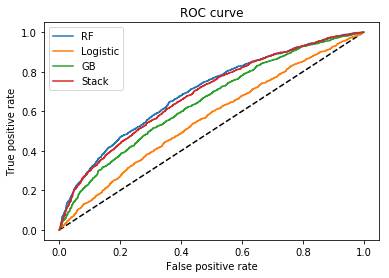

C:\Users\pgood\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: Mean of empty slice.
C:\Users\pgood\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
rs  = KFold(n_splits=10, shuffle=True)
splits = rs.split(X, Y, groups = groups)
residuals = []
probs_regr = []
scores_regr = []
scores_logistic = []
all_probs = []
probs_log_main = []
scores_log_main = []
increase_rf = []
increase_log = []
increase_gb = []
scores_gb = []
probs_gb = []
aucs_gb = np.zeros(10)
aucs_st = np.zeros(10)
aucs_rf = np.zeros(10)
fprs_gb, tprs_gb, fprs_rf, tprs_rf, fprs_log, tprs_log, fprs_st, tprs_st = [], [], [], [],[],[],[], []
i = 0
for train, test in splits:
    x_train, y_train = X.iloc[train,:], Y.iloc[train,:]
    x_test, y_test, actuals_test = X.iloc[test, :],  Y.iloc[test,:], actuals[test] 

    logistic_test = (y_test.values > 0)*1
    logistic_train = (y_train.values > 0)*1

    gb = GradientBoostingClassifier(min_samples_leaf= 5,
          min_samples_split= 10,
          max_depth = 3,
          subsample = .8,
          n_estimators = 1000)    
    gb.fit(x_train, logistic_train.ravel())
    scores_gb.append(gb.score(x_test, logistic_test))
    probs3 = gb.predict_proba(x_test)
    probs_gb.append(probs3)
    increase_gb.append(actuals_test[probs3[:,1] > .65].mean())
    fpr_gb, tpr_gb, _ = roc_curve(logistic_test, probs3[:,1].ravel(), 1)
    fprs_gb.append(fpr_gb)
    tprs_gb.append(tpr_gb)
    #rf regression (gives continuous predictions)
    regr = RandomForestClassifier(min_samples_leaf = 10, n_estimators = 100, min_samples_split = 10)
    regr.fit(x_train, logistic_train.ravel())
    scores_regr.append(regr.score(x_test, logistic_test))
    probs2 = regr.predict_proba(x_test)
    probs_regr.append(probs2)
    increase_rf.append(actuals_test[probs2[:,1] > .65].mean())
    fpr_rf, tpr_rf, _ = roc_curve(logistic_test, probs2[:,1].ravel(), 1)
    fprs_rf.append(fpr_rf)
    tprs_rf.append(tpr_rf)
    #pred = regr.predict(x_test)
    
    
    #logistic classifier on original data
    log_regr = LogisticRegression()
    log_regr.fit(x_train, logistic_train.ravel())
    probs1 = log_regr.predict_proba(x_test)
    probs_log_main.append(probs1)
    scores_log_main.append(log_regr.score(x_test, logistic_test))
    increase_log.append(actuals_test[probs1[:,1] > .6].mean())#find avg price change when classifier prob > .6
    fpr_log, tpr_log, _ = roc_curve(logistic_test, probs1[:,1].ravel(), 1)    
    fprs_log.append(fpr_log)
    tprs_log.append(tpr_log)
    
    all_probs = np.array([probs2[:,1].ravel(), probs3[:,1].ravel()]).mean(axis = 0)
    fpr_st, tpr_st, _ = roc_curve(logistic_test, all_probs.ravel(), 1)
    fprs_st.append(fpr_st)
    tprs_st.append(fpr_st)

    aucs_rf[i] = auc(fpr_rf, tpr_rf)
    aucs_gb[i] = auc(fpr_gb, tpr_gb)
    aucs_st[i] = auc(fpr_st, tpr_st)
    i += 1


plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_log, tpr_log, label='Logistic')
plt.plot(fpr_gb, tpr_gb, label='GB')
plt.plot(fpr_st, tpr_st, label='Stack')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


mse = np.array(residuals).mean()

#df, sds = get_train_data()
#X, Y, df2 = prep_data(sds,df)
#auc_rf, aug_gb = test_model(df2, X, Y)

In [12]:
def impl_vol_func(vol, df):
    from scipy.stats import norm
    
    rf = df['rf']
    t = df['time_left']
    top_d1 = np.log( df.indexPrice/df.strike) + (rf + ((vol)**2)/2)*t
    bottom_d1 = vol * np.sqrt(t)
    d1 = top_d1/bottom_d1

    d2 = d1 - vol * np.sqrt(t)
    if df.option_type == 'C':
        return  df.price - (df.indexPrice*norm.cdf(d1) - df.strike * np.exp(-rf*t) * norm.cdf(d2))
    else:
        return df.price - (df.strike * np.exp(-rf * t) * norm.cdf(-d2) - df.indexPrice * norm.cdf(-d1))

In [18]:
def bs_price(vol, df):
    from scipy.stats import norm
    
    rf = df['rf']
    t = df['time_left']
    top_d1 = np.log( df.indexPrice/df.strike) + (rf + ((vol)**2)/2)*t
    bottom_d1 = vol * np.sqrt(t)
    d1 = top_d1/bottom_d1

    d2 = d1 - vol * np.sqrt(t)
    if df.option_type == 1:
        return  df.indexPrice*norm.cdf(d1) - df.strike * np.exp(-rf*t) * norm.cdf(d2)
    else:
        return df.strike * np.exp(-rf * t) * norm.cdf(-d2) - df.indexPrice * norm.cdf(-d1)

In [14]:
def vega(vol, df):
    from scipy.stats import norm
    
    rf = df['rf']
    t = df['time_left']

    top_d1 = np.log(df.indexPrice/df.strike) + (rf + ((vol)**2)/2)*t
    bottom_d1 = vol * np.sqrt(t)
    d1 = top_d1/bottom_d1
    return df.indexPrice * np.sqrt(t) * norm.cdf(d1, 0.0, 1.0)

In [15]:
def get_implied_vol(df):
    from scipy.optimize import fsolve
    
    impl_vol = fsolve(impl_vol_func, df['sd'], args = (df,), fprime = vega)
    
    return impl_vol[0]

In [23]:
from datetime import datetime
only_calls = df2.loc[df2['timeStamp'] >= datetime(2018,1,1)]

In [24]:
only_calls['implied_vol'] = only_calls.apply(get_implied_vol, axis = 1)

C:\Users\pgood\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\pgood\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


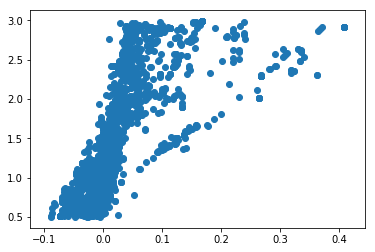

In [39]:
only_calls = only_calls.loc[(only_calls['implied_vol'] > .5) & (only_calls['implied_vol'] < 3)& (only_calls['option_type'] == 1)]
plt.scatter(only_calls['strike_dist'], only_calls['implied_vol'])
plt.show()

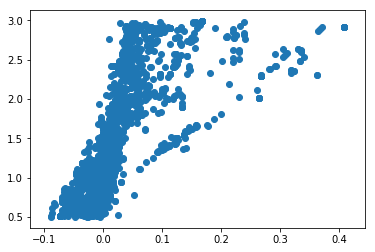

In [38]:
only_puts = only_calls.loc[(only_calls['implied_vol'] > .5) & (only_calls['implied_vol'] < 3)& (only_calls['option_type'] == 2)]
plt.scatter(only_calls['strike_dist'], only_calls['implied_vol'])
plt.show()

In [36]:
dict(zip(['cum_volume', 'strike_dist', 'price_delta', 'time_left', 'option_type'], gb.feature_importances_))

{'cum_volume': 0.15844856751071437,
 'option_type': 0.010899573153382887,
 'price_delta': 0.23746578479453165,
 'strike_dist': 0.2659652624286884,
 'time_left': 0.3272208121126836}

In [37]:
dict(zip(['cum_volume', 'strike_dist', 'price_delta', 'time_left', 'option_type'], regr.feature_importances_))

{'cum_volume': 0.20323676995921516,
 'option_type': 0.015203363578067706,
 'price_delta': 0.277434478161629,
 'strike_dist': 0.2494446597618289,
 'time_left': 0.25468072853925927}